In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle

In [2]:
# Set the random seed for reproducibility
random.seed(42)

In [3]:
# Load Dataset
file_path = "/Users/Sebastiano/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,job1625742,0,44,2,Na,0.69429,199.6236,335.6153,28.3185,300.4497,...,3.8688,0.036558,-8.5431,2.6760,0.025287,2.2615,0.021370,2.9461,0.027839,-26.2910
1,Paziente 11,0,32,0,Na,0.68846,51.0280,481.9302,38.3537,481.5288,...,3.3313,0.030871,6.7254,2.0754,0.019233,2.0308,0.018820,2.1096,0.019550,-3.8050
2,Paziente 15,0,60,1,Psychosis,0.69406,51.4202,467.2516,36.3049,466.9031,...,1.5857,0.014578,25.8052,1.9698,0.018109,1.9060,0.017523,2.0310,0.018671,-6.3473
3,Paziente 10,1,53,1,Seizure,0.90248,34.1831,652.3232,40.5777,649.4136,...,2.9130,0.024867,7.8399,2.2472,0.019183,2.3174,0.019782,2.1936,0.018726,5.4860
4,Paziente 5,0,43,0,Na,0.76373,94.5834,548.5729,41.4234,547.8604,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [4]:
# Drop unwanted columns
df = df.drop(['Patient', 'Gender', 'Age', 'Event', 'Scale factor', 'SNR'], axis='columns')

# Normalize the selected features
features_to_normalize = df.columns.difference(['NP-SLE'])
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


In [5]:
# Separate features and target variable
X = df.drop(['NP-SLE'], axis=1)
y = df['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Feature Selection using Elastic Net
elastic_net = ElasticNetCV(cv=5, random_state=42)
elastic_net.fit(X_train, y_train)

# Select features based on Elastic Net
model = SelectFromModel(elastic_net, prefit=True)
X_train_selected = model.transform(X_train)
X_test_selected = model.transform(X_test)

# Train Extremely Randomized Trees Classifier
ext_trees = ExtraTreesClassifier(random_state=42)
ext_trees.fit(X_train_selected, y_train)

# Predictions and Evaluation
y_pred = ext_trees.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print accuracy and classification report
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         6

    accuracy                           0.90        10
   macro avg       0.89      0.83      0.82        10
weighted avg       0.93      0.90      0.89        10



/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies = []
reports = []
all_y_true = []
all_y_pred = []


for train_index, test_index in kf.split(X):
    # Splitting Data
    X_train_kfold, X_test_kfold = X.iloc[train_index], X.iloc[test_index]
    y_train_kfold, y_test_kfold = y.iloc[train_index], y.iloc[test_index]

    # Feature Selection using Elastic Net
    elastic_net = ElasticNetCV(cv=5, random_state=42)
    elastic_net.fit(X_train_kfold, y_train_kfold)
    model = SelectFromModel(elastic_net, prefit=True)
    X_train_kfold_selected = model.transform(X_train_kfold)
    X_test_kfold_selected = model.transform(X_test_kfold)

    # Train Extremely Randomized Trees Classifier
    ext_trees = ExtraTreesClassifier(random_state=42)
    ext_trees.fit(X_train_kfold_selected, y_train_kfold)

    # Predictions and Evaluation
    y_pred_kfold = ext_trees.predict(X_test_kfold_selected)
    accuracies.append(accuracy_score(y_test_kfold, y_pred_kfold))
    reports.append(classification_report(y_test_kfold, y_pred_kfold))
    # Store predictions and true labels
    all_y_true.extend(y_test_kfold)
    all_y_pred.extend(y_pred_kfold)

# Average accuracy
average_accuracy = np.mean(accuracies)
overall_report = classification_report(all_y_true, all_y_pred)

print("Average Accuracy:", average_accuracy)
print("Overall Classification Report:\n", overall_report)

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-02, tolerance: 2.368e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt

Average Accuracy: 0.5355555555555556
Overall Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.15      0.15        13
           1       0.21      0.21      0.21        14
           2       1.00      1.00      1.00        20

    accuracy                           0.53        47
   macro avg       0.46      0.46      0.46        47
weighted avg       0.53      0.53      0.53        47



/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


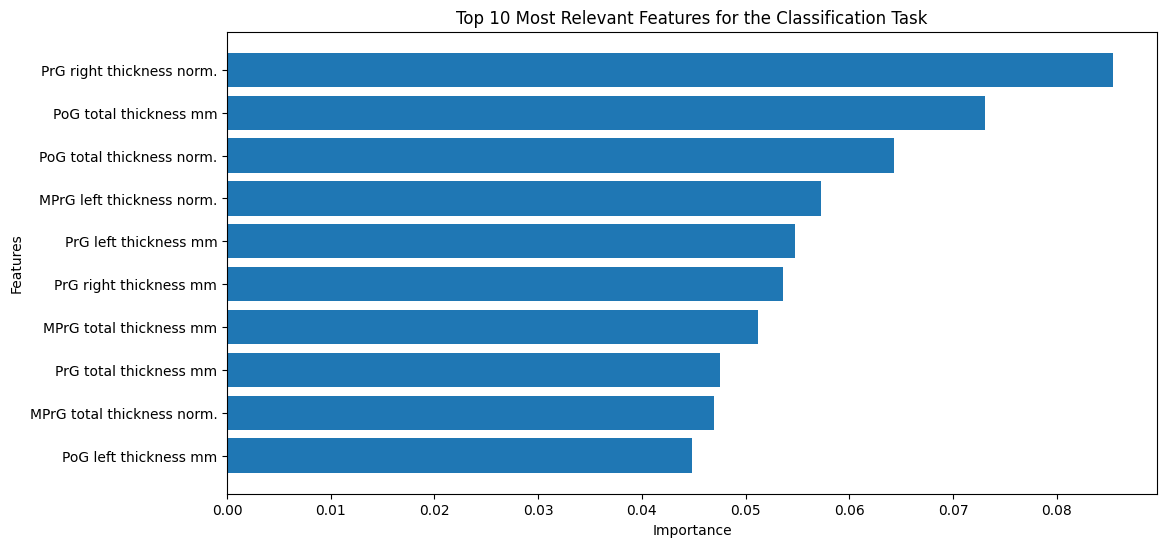

In [14]:
import matplotlib.pyplot as plt
import pandas as pd


# Get feature importances
feature_importances = ext_trees.feature_importances_

# Get feature names
# When using SelectFromModel, we need to first get the support indices (boolean mask or indices of selected features)
selected_features = X_train.columns[model.get_support()]

# Create a DataFrame for easier handling
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Relevant Features for the Classification Task')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
